## **흉부X선 사진으로 폐렴 분류하기**  
### **1. 데이터 전처리**    
### **2. VGG-16 모델 구성**  
### **3. 학습 및 결과 확인**  
### **4. 텐서보드 확인 및 테스트**

In [20]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import urllib
import cv2
import glob
import warnings
warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format = 'retina'

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras.utils import image_dataset_from_directory

In [22]:
# 운영체제별 한글 폰트 설정
if os.name == 'posix': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

---

## **1. 데이터 전처리**

- ### **데이터 세트 구성(5,863)**

ㄴtrain(5216)  
    ㄴ NORMAL(1,341)    
    ㄴ PNEUMONIA(3,875)    
ㄴ val(16)    
    ㄴ NORMAL(8)    
    ㄴ PNEUMONIA(8)    
ㄴ test(624)  
    ㄴ NORMAL(234)    
    ㄴ PNEUMONIA(390)    

- ### **데이터 출처**  
광저우 여성 아동 의료 센터 (Guangzhou Women and Children’s Medical Center, Guangzhou)  
1세~5세 소아 환자  


![]()
<img src="https://imgur.com/W7cH7Pc.png" width="500px" height="200px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>

- 정상 흉부 X선(왼쪽) : 비정상적인 불투명 영역이 없는 깨끗한 폐  
- 세균성 폐렴(가운데) : 사진 왼쪽상단 화살표 지점에서 차이를 볼 수 있음
- 바이러스성 폐렴(오른쪽)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/Users/yena/Desktop/python_study/AIFFEL/MAIN_QUEST/data/chest_xray/'
# data_path = '/content/drive/MyDrive/케창딥/chest_xray/'

train_dataset = image_dataset_from_directory(
    data_path + 'train',
    image_size=(224, 224),
    batch_size=32
)
val_dataset = image_dataset_from_directory(
    data_path + 'val',
    image_size=(224, 224),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    data_path + 'test',
    image_size=(224, 224),
    batch_size=32
)

Found 5216 files belonging to 2 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-06-22 15:25:29.574760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-22 15:25:29.575310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print('데이터 배치 크기 : ', data_batch.shape)
    print('레이블 배치 크기 : ', labels_batch.shape)
    break

2023-06-22 15:25:31.033891: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


데이터 배치 크기 :  (32, 224, 224, 3)
레이블 배치 크기 :  (32,)


In [ ]:
# 컨브넷에 추가할 데이터 증식 단계 정의
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal_and_vertical'),    # 수평하게 랜덤으로 뒤집고 수직으로 랜덤하게 뒤집음
        layers.RandomRotation(0.1),                      # [-10%, +10%] 범위 내에서 랜덤값 만큼 이미지 회전
        layers.RandomZoom(0.2)                           # [-20%, +20%] 범위 내에서 랜덤한 비율만큼 확대 또는 축소
    ]
)

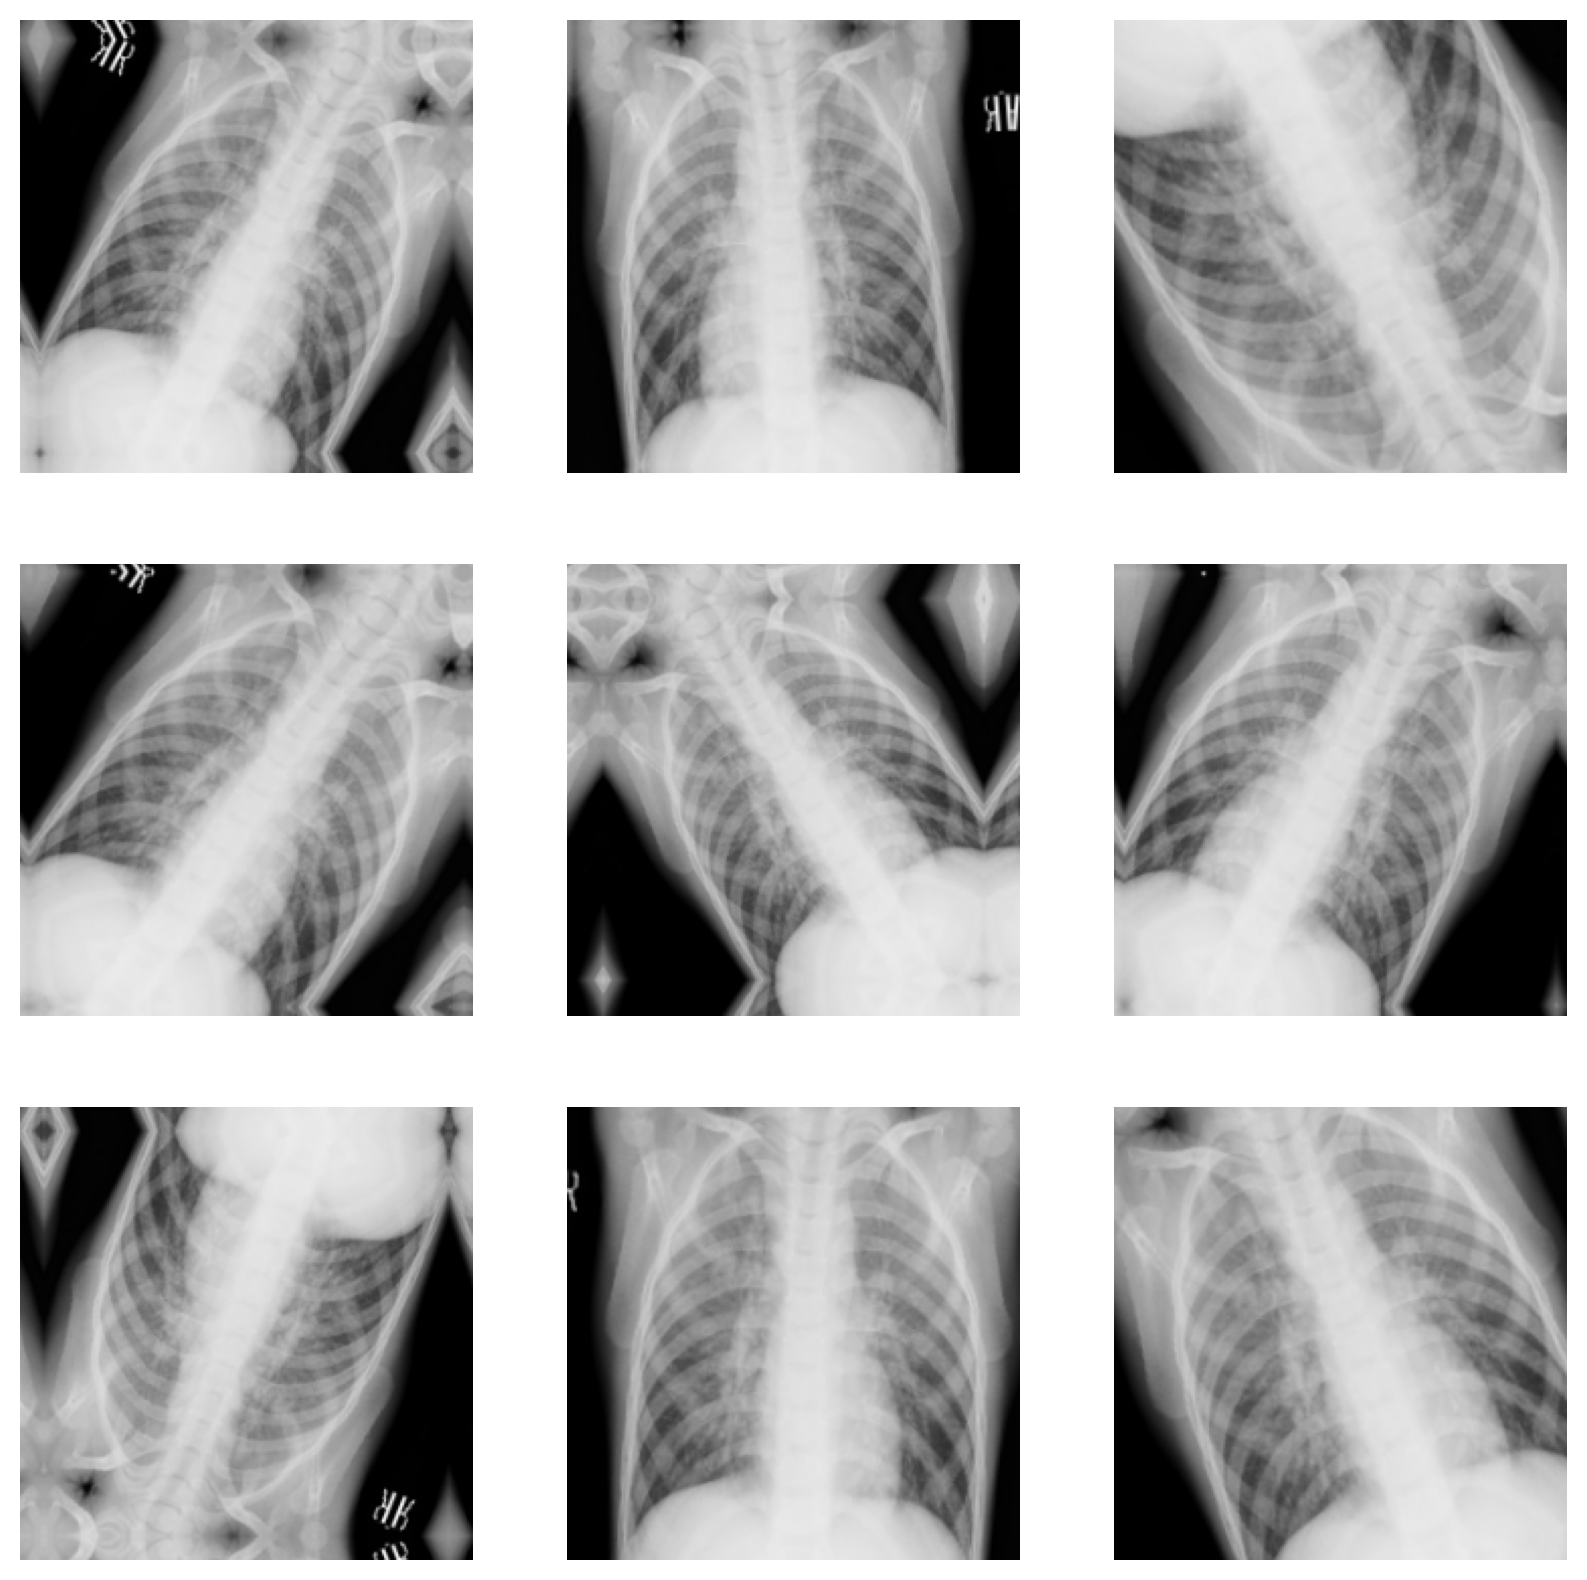

In [ ]:
# 랜덤 증식 이미지 출력
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

---

## **2. VGG-16 모델 구성**  


In [39]:
input_shape = (224,224,3)
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# model = tf.keras.models.Sequential()

x = layers.Conv2D(input_shape = input_shape, filters = 64, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding = 'same')(x)
x = layers.Conv2D(filters= 64, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.MaxPooling2D(pool_size= (2,2))(x)

# x = layers.Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.Conv2D(filters= 128, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.MaxPooling2D(pool_size= (2,2))(x)

# x = layers.Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
# x = layers.Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.Conv2D(filters= 256, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.MaxPooling2D(pool_size= (2,2))(x)

# x = layers.Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
# x = layers.Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
x = layers.MaxPooling2D(pool_size= (2,2))(x)

# x = layers.Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
# x = layers.Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
# x = layers.Conv2D(filters= 512, kernel_size= (3,3), strides= (1,1), activation= 'relu', padding= 'same')(x)
# x = layers.MaxPooling2D(pool_size= (2,2))(x)

# fully connected
x = layers.Flatten()(x)
# x = layers.Dense(4096, activation='relu')(x)
# x = layers.Dense(4096, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_59 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                           

---

## **3. 학습 및 결과 확인**  


In [40]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
callbacks = [
    # keras.callbacks.ModelCheckpoint(
    #     filepath='model.keras',
    #     save_best_only=True,
    #     monitor='val_loss'
    # ),
    keras.callbacks.TensorBoard(
        log_dir='230622_dir',
    )
]

history = model.fit(train_dataset,
                    epochs=20,
                    verbose=2,
                    validation_data=val_dataset,
                    callbacks=[callbacks])

Epoch 1/20


2023-06-22 16:13:25.584968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


163/163 - 86s - loss: 0.6809 - accuracy: 0.7320 - val_loss: 0.8114 - val_accuracy: 0.5625 - 86s/epoch - 530ms/step
Epoch 2/20


2023-06-22 16:14:51.372631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


163/163 - 80s - loss: 0.4060 - accuracy: 0.8140 - val_loss: 0.6232 - val_accuracy: 0.7500 - 80s/epoch - 491ms/step
Epoch 3/20
163/163 - 81s - loss: 0.3174 - accuracy: 0.8763 - val_loss: 0.6149 - val_accuracy: 0.7500 - 81s/epoch - 499ms/step
Epoch 4/20
163/163 - 82s - loss: 0.2858 - accuracy: 0.8842 - val_loss: 0.7010 - val_accuracy: 0.8125 - 82s/epoch - 504ms/step
Epoch 5/20
163/163 - 81s - loss: 0.2469 - accuracy: 0.9039 - val_loss: 0.9362 - val_accuracy: 0.7500 - 81s/epoch - 497ms/step
Epoch 6/20
163/163 - 81s - loss: 0.2260 - accuracy: 0.9141 - val_loss: 1.1407 - val_accuracy: 0.6250 - 81s/epoch - 497ms/step
Epoch 7/20
163/163 - 83s - loss: 0.2281 - accuracy: 0.9147 - val_loss: 0.6339 - val_accuracy: 0.7500 - 83s/epoch - 511ms/step
Epoch 8/20
163/163 - 82s - loss: 0.2016 - accuracy: 0.9277 - val_loss: 0.9443 - val_accuracy: 0.6250 - 82s/epoch - 501ms/step
Epoch 9/20
163/163 - 80s - loss: 0.1943 - accuracy: 0.9250 - val_loss: 0.9201 - val_accuracy: 0.7500 - 80s/epoch - 492ms/step
Epo

<Figure size 640x480 with 0 Axes>

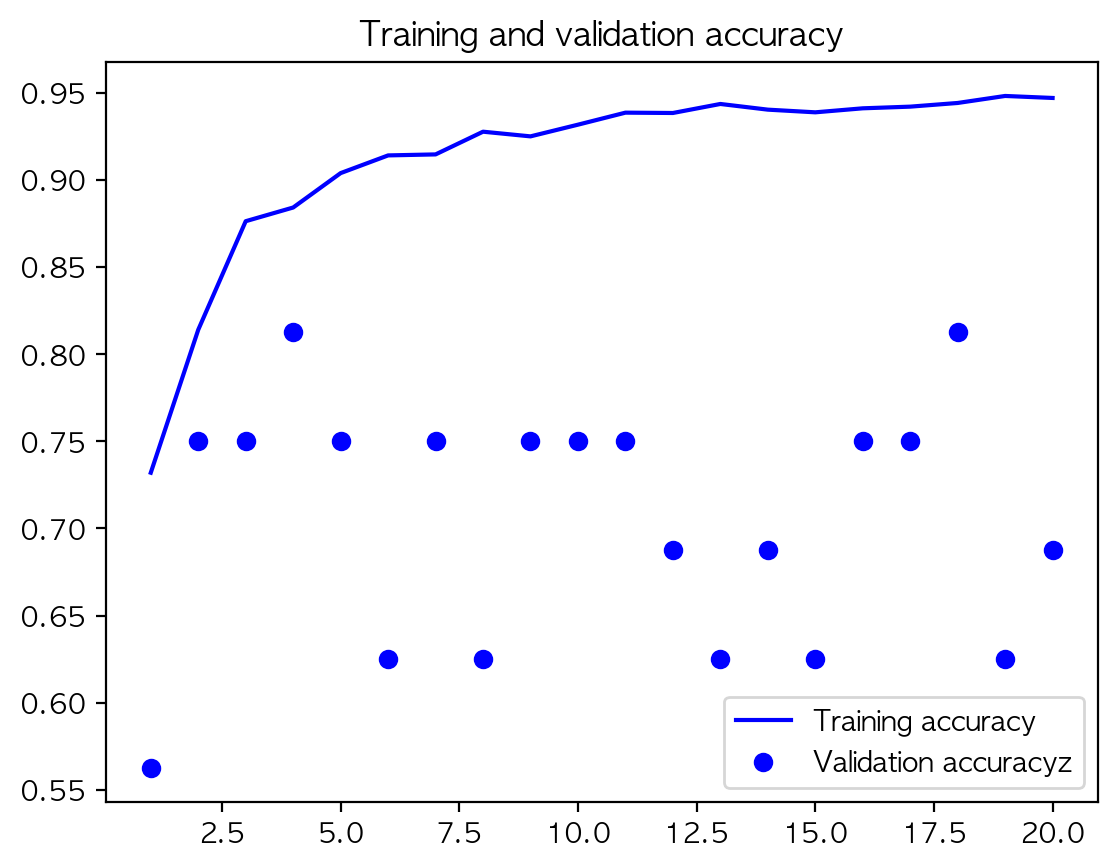

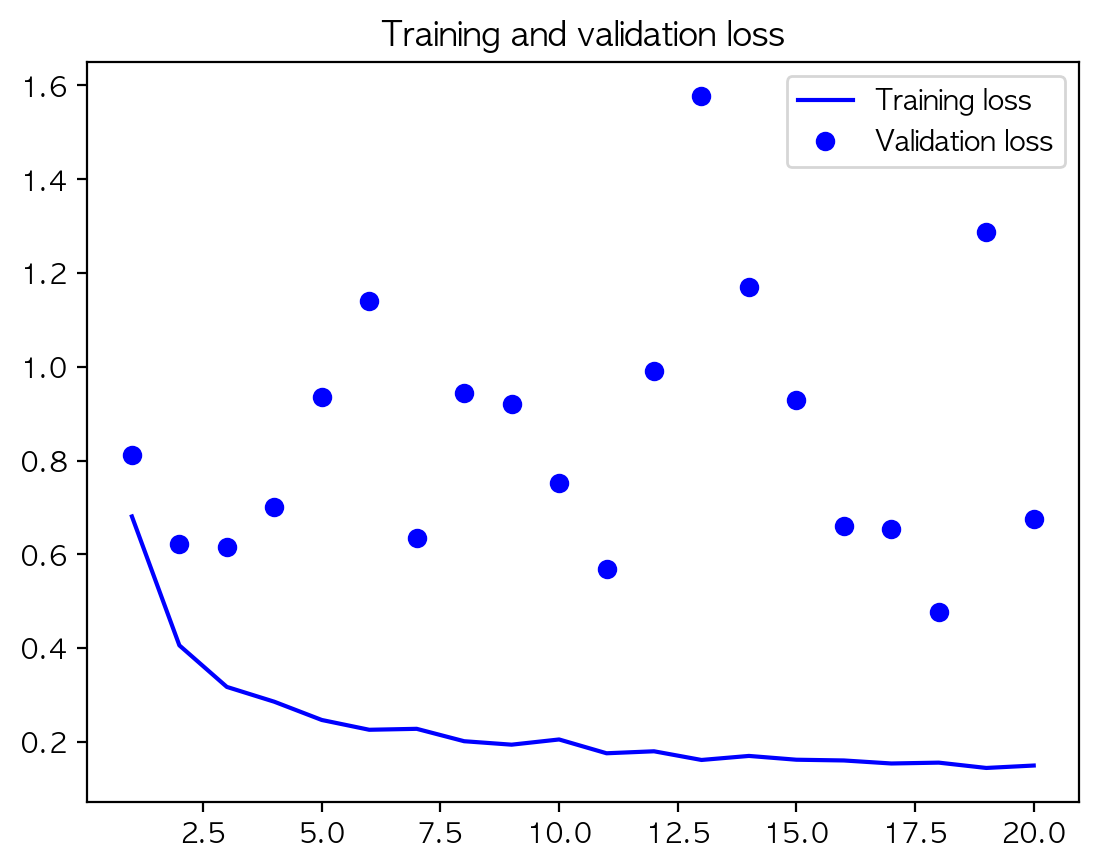

<Figure size 640x480 with 0 Axes>

In [43]:
# 결과 그래프
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history. history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracyz')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

## **4. 텐서보드 확인 및 테스트**  

In [51]:
# tensorboard
%load_ext tensorboard
%tensorboard --logdir 230622_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 36948), started 0:00:23 ago. (Use '!kill 36948' to kill it.)

In [50]:
test_model = keras.models.load_model('model.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트 정확도 : {test_acc:.3f}')

2023-06-22 16:42:15.931222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 6s 300ms/step - loss: 0.6715 - accuracy: 0.6250
테스트 정확도 : 0.625


## **고찰**  
- 기존 파일의 validation 데이터가 굉장히 적었다. train data를 분리해서 시도할 것.  
- 데이터셋에 맞는 파라미터의 수를 찾는게 중요한 것 같다. (VGG-16모델을 그대로 차용하기 보다는 적은데이터에 맞춰 줄인 것처럼)  